<a href="https://colab.research.google.com/github/yunmokoo/Hands-On_Machine_Learning/blob/main/Copy_of_Ch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Housing Example.

#Requirements.

Python >3.7

Scikit-Learn ≥ 1.0.1

In [1]:
#Python
import sys
assert sys.version_info >= (3, 7)

#Scikit-Learn
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

# Downloading the Data.

Normally, the dtata would be in relational database or other common data store, and across multiple tables/ documents/ files.

*In this project however,*
just downloading a single compressed file, ***housing.tgz***, will do it.

***housing.tgz*** contains a comma-separated values(CSV) file called, ***housing.csv***, with all the data.

In [3]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

When ***load_housing_data()*** is called, it looks for the *datasets/housing.tgz* file.



Using DataFrame's *head()* method, look at top five rows of data.

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Using *info()* method, get quick description of the data, in particular the total number of rows, each attribute’s type, and the number of non-null values:

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Notice the "total_bedrooms" attribute is missing 207(20433 out of 20640).

Find out what categories exist and how many dsitricts belong to each category by using the "value_counts()" method.

In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Now, plot a histogram to get a feel of the type of data that you are dealing with.

In [7]:
import matplotlib.pyplot as plt

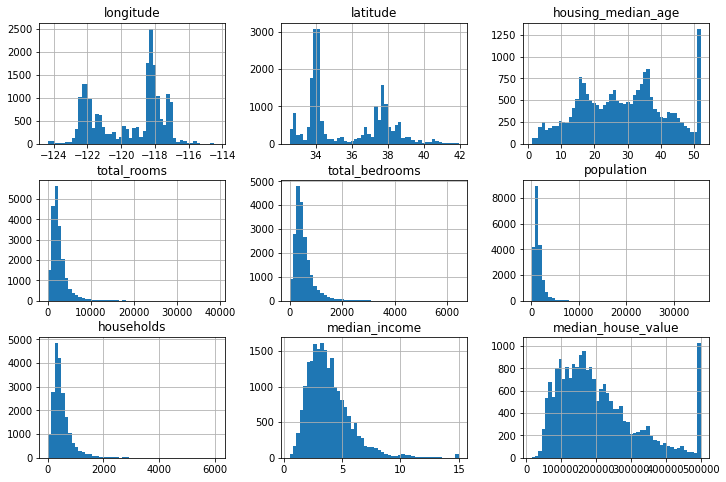

In [8]:
housing.hist(bins = 50, figsize = (12, 8))
plt.show()

#Notice few things...
median income attribute is capped at 15(15.0001 fr) and at 0.5(0.4999 fr).

Other features are also capped at certain value...

these features have very different scales and mostly skewed right...

# **Create a test set**

Typically 20% (leff if data is huge) is put away for test set...

In [9]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

You can utilize this function like this...

In [10]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)

16512

In [11]:
len(test_set)

4128

This works...
# NOT!
If run again, it will generate a **different test set**!

That will cause the algo to see the whole dataset, which makes test set meaningless.

One solution is to save the test set on the first run and then load it in subsequent
runs.

Another option is to set the random number generator’s seed (e.g., with
np.random.seed(11)) before calling np.random.permutation() so that it always
generates the same shuffled indices.


**However, both these solutions will break the next time you fetch an updated dataset.**


> Common solution is to use each instance's identifier to decide whether or not it should go in the test set.



For example, compute a hash of each instance's identifier and put that instance in the test set if the hash is lower than or equal to 20% of the maximum hash value.

This ensures that the
test set will remain consistent across multiple runs, even if you refresh the dataset.

# Here is a possible implementation:

In [12]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
  return crc32(np.int64(identifier)) < test_ratio * 2 ** 32

def split_data_with_id_hash(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

Since the housing dataset does not have identifier column... use the row index as the ID.

In [13]:
housing_with_id = housing.reset_index() #Adds an 'index' column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

Using the index as a unique identifier warns that the index must be ordered correctly and no indexes can be deleted.

If not possible...

> Use the latitude and longitude as ID.

In [14]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

**Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways.**

> train_test_split() == shuffle_and_split_data() function

There is also a **random_state** parameter that allows random generator seed.

Second, you can pass it multiple datasets with
an identical number of rows, and it will split them on the same indices (this is very useful, for example, if you have a separate DataFrame for labels)

In [15]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

So far, these are purely a random sampling methods.
> This is fine when the dataset is large enough (especially relative to the number of attributes)

but if it
is not, you run the risk of significant sampling bias.

# New Section